In [13]:
%matplotlib inline
import cv2
import os,sys
import pickle
import scipy.stats
import sklearn.metrics

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import norm
from sklearn import preprocessing
from itertools import combinations
from PIL import Image

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.insert(1, './utilities/')

from utility_functions import *

# Load the Data

In [4]:
# Loaded a set of images
root_dir = "../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


# Data Preprocessing

In [22]:
def hist_of_all_features_normal_fit():
    """
    performs a histogram of the distribution of all the parameters in the dataset 
    and fits a normal distribution to each parameter separately
    parameters:
        dataset: the dataset to plot
    """
    n = len(imgs)
    #n = 2
    nb_channels = imgs[0].shape[2]
    fig, ax = plt.subplots(n,nb_channels)

    for i in range(n):
        for j in range(nb_channels):
            ax[i,j].hist(imgs[i][:,:,j].ravel(), bins = 30)
            ax[i,j].set_title(i,fontsize=40)

    fig.set_figheight(150)
    fig.set_figwidth(150)
    plt.suptitle("Distribution of all the features",fontsize=150)
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.show()
    
hist_of_all_features_normal_fit()

In [18]:
scaler = preprocessing.StandardScaler()

for i in range(len(imgs)):
    for j in range(3):
        scaler.fit(imgs[i][:,:,j])
        imgs[i][:,:,j] = scaler.transform(imgs[i][:,:,j])
#imgs = [normalize(imgs[i]) for i in range(len(imgs))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


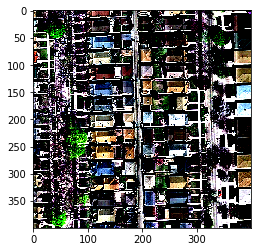

In [21]:
plt.imshow(imgs[0])
plt.show()

## Split the images into smaller patches

In [85]:
# Extract patches from input images
# size = 10(nb_images)*625(n_patches_per_image)*16*16(size_patch)*3(nb_channels)
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
#return array of size 6250 containing all the 625 patches for all the 10 training images
#gt has only 0 or 1 values
#img has an rgb value of size 3 for each point

# Extraction of Features from the images

In [86]:
#TODO: More features 

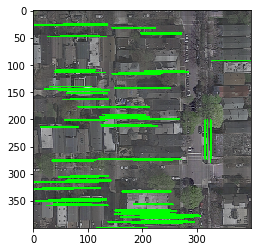

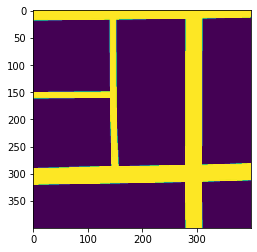

In [88]:
#line detection
#TODO: transformer ca en feature
def proba_hough_tranform(img):
    img = img_float_to_uint8(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #edges = cv2.Canny(gray,50,150,apertureSize = 3)
    edges = ndimage.gaussian_laplace(gray, sigma=2.5)
    
    #plt.imshow(edges)
    #plt.show()
    minLineLength = 100
    maxLineGap = 70
    lines = cv2.HoughLinesP(edges,0.01,np.pi/360,100,minLineLength,maxLineGap)
    for i in range(len(lines)):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

    #cv2.imwrite('houghlines5.jpg',img)
    plt.imshow(img)
    plt.show()
   
proba_hough_tranform(imgs[3])
plt.imshow(gt_imgs[3])

In [95]:
#Features definition
def features_definition(img_patches):
    print("start")
    #X1 = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))]) # dim 6
    print("start")
    #X2 = np.asarray([ laplace_gaussian_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 102
    print("start")
    #X3 = np.asarray([ horizontal_and_vertical_edge_detection(img_patches[i]) for i in range(len(img_patches))]) # dim 6
    print("start")
    X4 = np.asarray([ get_grey_features(get_gray_mask(img_patches[i])) for i in range(len(img_patches))]) # dim 32
    print("stop")
    #X = np.concatenate((X2,X3,X4),axis=1) # dim 13
    #X = feature_expansion(X,6) # dim = dim * degree
    X = add_offset(X4) # dim = dim + 1
    
    print(X4.shape,X.shape)

    return X

In [96]:
X = features_definition(img_patches)

start
start
start
start
stop
(6250, 32) (6250, 33)


In [97]:
#PCA to determine which features are the most relevant
pca = PCA(n_components=10, svd_solver='full')
pca.fit(X)                 
PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(np.where(pca.components_[0,:] > 0.10))
#PCA indicates that only the grey features contribute to explanation of the variance

[0.57143341 0.07993361 0.07474059 0.03689762 0.03456887 0.02198076
 0.02089919 0.01500815 0.01363176 0.01167798]
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),)


### Definition of the output y

In [98]:
### Definition of two classes for the patches

# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

#the class foreground has a bit of road in it (25% min)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [99]:
# Print feature statistics
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 33
Number of classes = 1
Class 0: 4915 samples
Class 1: 1335 samples


In [ ]:
colors = ['c','m']
plt.scatter(pca.components_[0],pca.components_[1],c=label, cmap=matplotlib.colors.ListedColormap(colors))

# Training of the model

## 1) Logistic regression

In [100]:
# train a logistic regression classifier
from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e4, class_weight="balanced",solver='liblinear',penalty='l1')
logreg.fit(X, Y)

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]
recall = len(list(set(Yn) & set(Zn))) / float(len(Z)) #Recall = TPR
precision = len(list(set(Yn) & set(Zn))) / float(len(Y))
F1 = 2*(recall*precision)/(recall+precision)
print('F1 Score = ' + str(F1))

F1 Score = 0.11968


In [ ]:
#Best score yet: 0.230769

In [ ]:
#we have to add more features !! -> improve edge detection

# Display of results

In [ ]:
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx],patch_size)
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 1], Xi[:, 10], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)